In [224]:
import multiprocessing
import random
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from src.environments import WirelessCommunicationsEnv
from src.utils import Discretizer
from src.sampler import PendulumTrajectorySampler, EpsilonGreedyPendulumTrajectorySampler
from src.trainer import QNetworkTrainer, QNetworkTester
from src.models import PARAFAC

In [326]:
ts = [20, 15, 20, 10]
p_harv = [0.2, 0.2, 0.4, 0.2]
snrs = [10, 10, 10, 20]

envs = [WirelessCommunicationsEnv(
    T=1_000,
    K=2,
    snr_max=snrs[i],
    snr_min=2,
    snr_autocorr=0.7,
    P_occ=np.array(
        [  
            [0.4, 0.6],
            [0.6, 0.4],
        ]
    ),
    occ_initial=[1, 1],
    batt_harvest=1.0, 
    P_harvest=0.2, 
    batt_initial=10,
    batt_max_capacity=10,
    batt_weight=1.0, 
    queue_initial=5,
    queue_arrival=2,
    queue_max_capacity=20,
    t_queue_arrival=ts[i],
    queue_weight=0.2,
    loss_busy=0.8,  
) for i in range(len(ts))]

In [355]:
discretizer = Discretizer(
    min_points_states=[0, 0, 0, 0, 0, 0],
    max_points_states=[20, 20, 1, 1, 20, 10],
    bucket_states=[20, 20, 2, 2, 20, 20],
    min_points_actions=[0, 0],
    max_points_actions=[2, 2],
    bucket_actions=[10, 10],
)

In [356]:
nS = [20, 20, 2, 2, 20, 20]
nA = [10, 10]
nT = len(ts)
gamma = 0.99

In [357]:
def create_target(states_next, rewards, Q, tasks=None):
    if tasks is not None:
        idx_target = torch.cat((tasks.unsqueeze(1), states_next), dim=1)
    else:
        idx_target = states_next

    with torch.no_grad():
        q_target = rewards + gamma * Q(idx_target).max(dim=1).values

    return q_target

def create_idx_hat(states, actions, tasks=None):
    if tasks is not None:
        idx_hat = torch.cat((tasks.unsqueeze(1), states, actions), dim=1)
    else:
        idx_hat = torch.cat((states, actions), dim=1)
    return idx_hat

def update_model(s_idx, sp_idx, a_idx, r, Q, opt, tasks=None):
    for factor in Q.factors:
        q_target = create_target(sp_idx, r, Q, tasks)
        idx_hat = create_idx_hat(s_idx, a_idx, tasks)
        q_hat = Q(idx_hat)

        opt.zero_grad()
        loss = torch.nn.MSELoss()(q_hat, q_target)
        loss.backward()

        with torch.no_grad():
            for frozen_factor in Q.factors:
                if frozen_factor is not factor:
                    frozen_factor.grad = None

        opt.step()

def select_random_action() -> np.ndarray:
        a_idx = tuple(np.random.randint(discretizer.bucket_actions).tolist())
        return discretizer.get_action_from_index(a_idx), a_idx

def select_greedy_action(Q, s_idx: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        a_idx_flat = Q(s_idx).argmax().detach().item()
        a_idx = np.unravel_index(a_idx_flat, discretizer.bucket_actions)
        return discretizer.get_action_from_index(a_idx), a_idx

def select_action(Q, s_idx: np.ndarray, epsilon: float) -> np.ndarray:
    if np.random.rand() < epsilon:
        return select_random_action()
    return select_greedy_action(Q, s_idx)

# Mono-task

In [359]:
E = 3000
H = 100
lr = 0.01
eps = 1.0
eps_decay = 0.99999
eps_min = 0.01

k = 20
n_upd = 1

env_id = 0

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [360]:
Gs = []
Q = PARAFAC(dims=nS + nA, k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
ds = 0
for episode in range(E):
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        a_idx = torch.tensor(a_idx).unsqueeze(0)
        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        for _ in range(n_upd):
            update_model(s_idx, sp_idx, a_idx, r, Q, opt)

        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)

        # if h % 10 == 0:
    if episode % 10 == 0:
        G = run_test_episode(Q, env_id)
        Gs.append(G)
    print(f"\rEpoch: {episode} - Return: {G} - {eps}", end="")
    

Epoch: 1069 - Return: 36.270230028276096 - 0.3430066823174846644

KeyboardInterrupt: 

In [ ]:
states = []
actions = []
with torch.no_grad():
    G = 0
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a_idx = Q(s_idx).argmax().item()
        a = discretizer.get_action_from_index(a_idx)
        a_idx = torch.tensor(a_idx).unsqueeze(0)

        states.append(s)
        actions.append(a)

        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        G += r

        if d:
            break

        s = sp
        s_idx = sp_idx
states = np.array(states)
actions = np.array(actions)

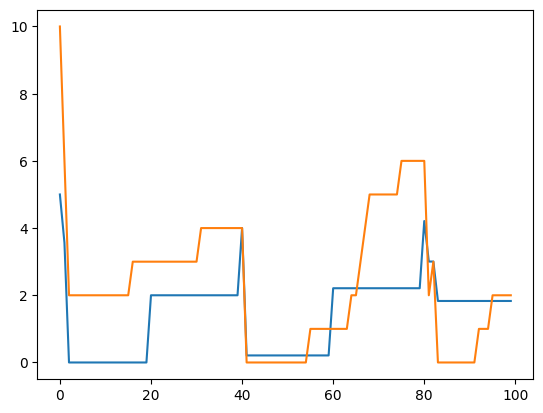

In [ ]:
plt.plot(states[:, -2]) # Queue
plt.plot(states[:, -1]) # Battery

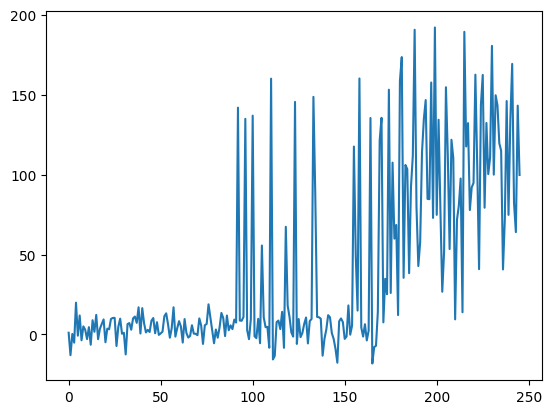

In [ ]:
plt.plot(Gs)

# Multi-task

In [348]:
E = 3000
H = 100
lr = 0.01
eps = 1.0
eps_decay = 0.99999
eps_min = 0.01
k = 20

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [349]:
Q = PARAFAC(dims=[nT] + nS + nA, k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=torch.tensor([env_idx]))

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)

        #if episode % 10 == 0:
        G = run_test_episode(Q, env_idx)
        Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]} - {eps}", end="")

Epoch: 1187 - Return: [143.38791531276115, 172.70388515624322, 133.60074467897513, 72.83591164024226] - 0.010111478241020385472

KeyboardInterrupt: 

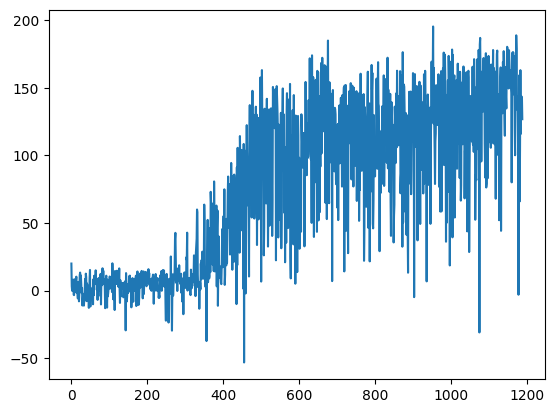

In [354]:
testid = 0
plt.plot(Gs[testid])

# Centralized

In [361]:
E = 1000
H = 100
lr = 0.01
eps = 1.0
eps_decay = 0.99999
eps_min = 0.01
k = 20

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [362]:
# SEQUENTIAL SAMPLING
Q = PARAFAC(dims=nS + nA, k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=None)

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
        if h % 10:
            G = run_test_episode(Q, env_idx)
            Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]}", end="")

Epoch: 999 - Return: [51.4393975082365, 31.393965937962, 126.08585404693933, 8.70740808575646]181]]]]]7]]

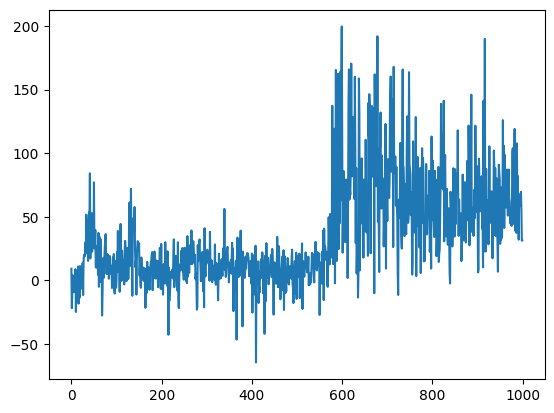

In [365]:
testid = 1
plt.plot(Gs[testid])